# Import required dependencies


In [1]:
import nltk
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import PorterStemmer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import pickle
import joblib
import gzip

In [ ]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

# Load data and perform EDA

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
df.nunique()

id        20800
title     19803
author     4201
text      20386
label         2
dtype: int64

In [ ]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
df['author'].value_counts()

author
Pam Key                              243
admin                                193
Jerome Hudson                        166
Charlie Spiering                     141
John Hayward                         140
                                    ... 
Michael Cutler                         1
Kate Zernike and Yamiche Alcindor      1
Alan Blinder and Timothy Williams      1
Hannah Seligson                        1
Jessica Purkiss                        1
Name: count, Length: 4201, dtype: int64

In [ ]:
df.fillna(' ', inplace=True)

In [ ]:
df['content'] = df['title'] + ' ' + df['author'] + ' ' + df['text']

In [ ]:
df.head()

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1,Iranian woman jailed for fictional unpublished...


In [ ]:
class Preprocessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.port_stem = PorterStemmer()

    def fit(self, X, y=None):
        return self
    
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)        
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = text.strip()
        text = word_tokenize(text)
        text = [word for word in text if word not in self.stop_words]
        text = [self.lemmatizer.lemmatize(word) for word in text]
        return ' '.join(text)
    
    def stemming(self, text):
        words = text.split()
        stemmed_words = [self.port_stem.stem(word) for word in words]
        return ' '.join(stemmed_words)

    def transform(self, X, y=None):
        # Ensure X is a Series before applying operations
        if isinstance(X, str):
            X = pd.Series([X])
        return X.apply(lambda text: self.stemming(self.clean_text(text)))

In [ ]:
preprocessor = Preprocessing()
df['processed_content'] = preprocessor.transform(df['content'])


In [ ]:
df['processed_content'].head()

0    hous dem aid didnt even see comey letter jason...
1    flynn hillari clinton big woman campu breitbar...
2    truth might get fire consortiumnewscom truth m...
3    civilian kill singl u airstrik identifi jessic...
4    iranian woman jail fiction unpublish stori wom...
Name: processed_content, dtype: object

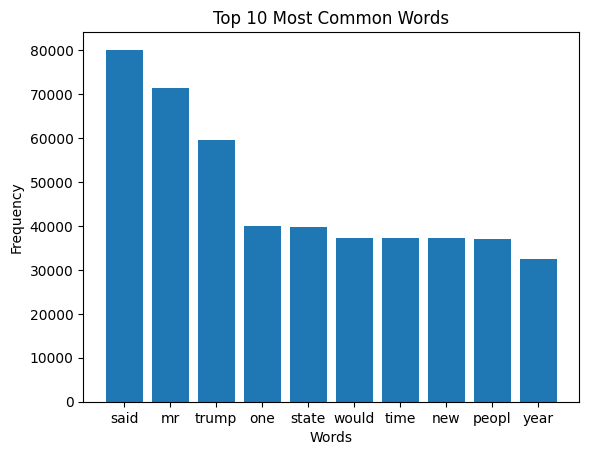

In [ ]:
# word frequency

def plot_word_frequency(text):
    words = text.split()
    counter = Counter(words)
    most_common = counter.most_common(10)
    x, y = zip(*most_common)
    plt.bar(x, y)
    plt.title('Top 10 Most Common Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

plot_word_frequency(df['processed_content'].str.cat(sep=' '))

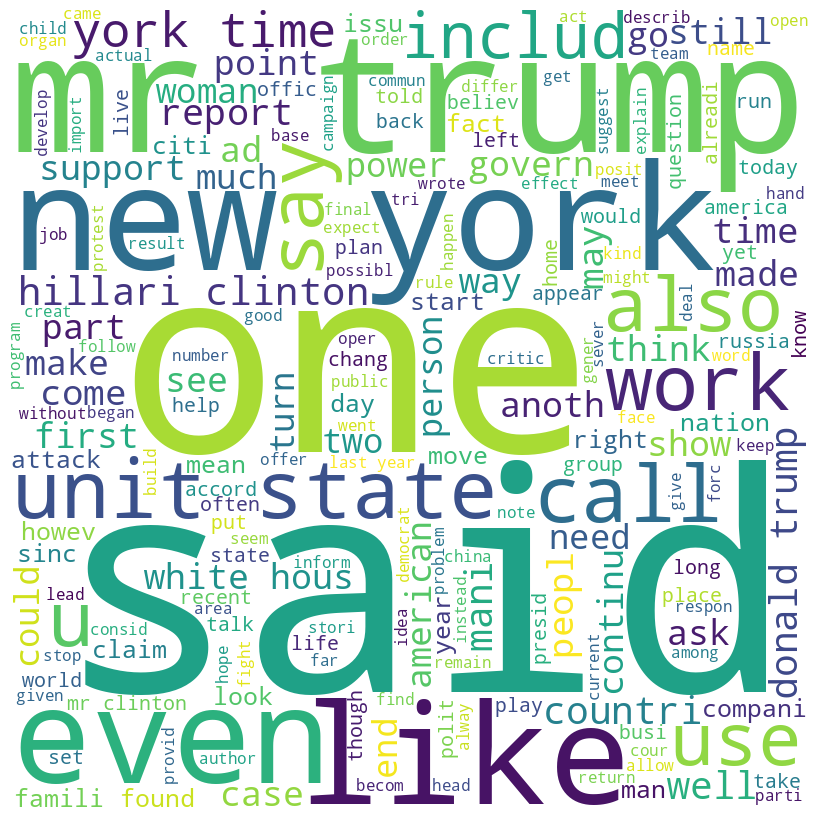

In [ ]:
# word cloud

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords.words('english'), 
                min_font_size = 10).generate(df['processed_content'].str.cat(sep=' '))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

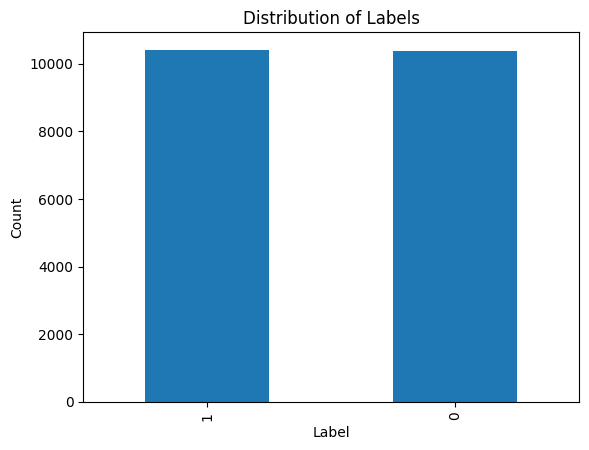

In [ ]:
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
df.head()

,id,title,author,text,label,content,processed_content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...,hous dem aid didnt even see comey letter jason...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",flynn hillari clinton big woman campu breitbar...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...,truth might get fire consortiumnewscom truth m...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...,civilian kill singl u airstrik identifi jessic...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1,Iranian woman jailed for fictional unpublished...,iranian woman jail fiction unpublish stori wom...


In [ ]:
# save preprocessed data only (dropping original text and content columns)
df[['processed_content', 'label']].to_csv('prepared_data.csv', index=False)


In [ ]:
# split the data
X = df['processed_content']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# tfidf vectorizer 
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
# logistic regression
lr = LogisticRegression(max_iter=1000) # Increased max_iter for convergence
lr.fit(X_train_tfidf, y_train)

y_pred_lr = lr.predict(X_test_tfidf)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2132
           1       0.95      0.95      0.95      2028

    accuracy                           0.95      4160
   macro avg       0.95      0.95      0.95      4160
weighted avg       0.95      0.95      0.95      4160



In [ ]:
# NB classifier
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

y_pred_nb = nb.predict(X_test_tfidf)

print("Multinomial Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

Multinomial Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      2132
           1       0.99      0.71      0.83      2028

    accuracy                           0.85      4160
   macro avg       0.88      0.85      0.85      4160
weighted avg       0.88      0.85      0.85      4160



In [ ]:
# decision tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_tfidf, y_train)

y_pred_dt = dt.predict(X_test_tfidf)

print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2132
           1       0.96      0.95      0.96      2028

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



In [ ]:
# random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tfidf, y_train)

y_pred_rf = rf.predict(X_test_tfidf)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2132
           1       0.95      0.88      0.92      2028

    accuracy                           0.92      4160
   macro avg       0.92      0.92      0.92      4160
weighted avg       0.92      0.92      0.92      4160



In [ ]:
# voting classifier
# Using the trained individual classifiers (lr, dt, rf)
vc = VotingClassifier(estimators=[('lr', lr), ('dt', dt), ('rf', rf)], voting='hard')

vc.fit(X_train_tfidf, y_train)

y_pred_vc = vc.predict(X_test_tfidf)

print("Voting Classifier Classification Report:")
print(classification_report(y_test, y_pred_vc))

Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2132
           1       0.98      0.96      0.97      2028

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



In [ ]:
# test the model

text = 'israel invaded rafa and killed 10 people'

# Ensure the preprocessor's transform method can handle a single string correctly
# The Preprocessing class was updated to handle this gracefully.
processed_text = preprocessor.transform(text)

text_tfidf = tfidf.transform(processed_text)

prediction = vc.predict(text_tfidf)
print(f"Prediction for the text '{text}': {prediction[0]}")

Prediction for the text 'israel invaded rafa and killed 10 people': 1


In [ ]:
# Save models with joblib and gzip for compression
print("Saving models...")
joblib.dump(vc, 'model.joblib.gz', compress=True)
joblib.dump(preprocessor, 'preprocessor.joblib.gz', compress=True)
joblib.dump(tfidf, 'tfidf.joblib.gz', compress=True)
print("Models saved as 'model.joblib.gz', 'preprocessor.joblib.gz', 'tfidf.joblib.gz'")

# Example of loading them back to verify
print("Loading models for verification...")
loaded_vc = joblib.load('model.joblib.gz')
loaded_preprocessor = joblib.load('preprocessor.joblib.gz')
loaded_tfidf = joblib.load('tfidf.joblib.gz')
print("Models loaded successfully.")

# You can optionally test the loaded model
test_text = 'israel invaded rafa and killed 10 people'
loaded_processed_text = loaded_preprocessor.transform(test_text)
loaded_text_tfidf = loaded_tfidf.transform(loaded_processed_text)
loaded_prediction = loaded_vc.predict(loaded_text_tfidf)
print(f"Prediction with loaded model for '{test_text}': {loaded_prediction[0]}")

Saving models...
Models saved as 'model.joblib.gz', 'preprocessor.joblib.gz', 'tfidf.joblib.gz'
Loading models for verification...
Models loaded successfully.
Prediction with loaded model for 'israel invaded rafa and killed 10 people': 1
